In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2

In [3]:
greyImage = r'albert-einstein_gray.jpg'
colourImage = r'tulips.jpg'
affineWarped = r'affine-transformed image.jpg'
projectiveWarped = r'projective_transformed.jpg'

In [5]:
I_grey = cv2.imread(greyImage,cv2.IMREAD_GRAYSCALE)
I_BGR = cv2.imread(colourImage)
I_affineWarped = cv2.imread(affineWarped,cv2.IMREAD_GRAYSCALE)
I_projectiveWarped = cv2.imread(projectiveWarped,cv2.IMREAD_GRAYSCALE)

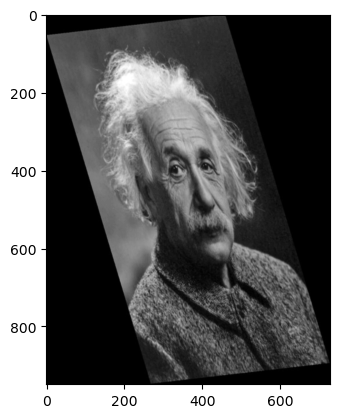

In [7]:
plt.imshow(I_affineWarped,cmap='gray')

In [9]:
def displayImageInActualSize(I):
    dpi = mpl.rcParams['figure.dpi']
    H,W = I.shape
    figSize = W/float(dpi) , H/float(dpi)
    fig = plt.figure(figsize = figSize)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    ax.imshow(I,cmap='gray')
    plt.show

In [11]:
def f_bilinearInterpolate(r,c,I):
    lc = int(c)
    rc = lc+1
    wr = c - lc
    wl = rc - c
    tr = int(r)
    br = tr+1
    wt = br-r
    wb = r-tr
    if tr >= 0 and br < I.shape[0] and lc >=0 and rc < I.shape[1]:
        a = wl*I[tr,lc] + wr*I[tr,rc]
        b = wl*I[br,lc] + wr*I[br,rc]
        g = wt*a + wb*b
        return np.uint8(g)
    else:
        return 0

In [13]:
def f_getExtentsProjective(T,rMax,cMax):
    coords = np.array([[0,0,1],[0,cMax-1,1],[rMax-1,0,1],[rMax-1,cMax-1,1]])
    A_dash = T.dot(coords.T)
    A_dash = A_dash/A_dash[2,:]
    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)
    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))
    H,W = maxR-minR+1, maxC-minC+1
    return minR,minC,maxR,maxC,H,W

In [15]:
def f_transformProjective(T,I_grey):
    rMax,cMax = I_grey.shape[0],I_grey.shape[1]
    minR,minC,maxR,maxC,H,W = f_getExtentsProjective(T,rMax,cMax)
    I2 = np.zeros((H,W),dtype='uint8')
    Tinv = np.linalg.inv(T)
    for new_i in range(minR,maxR):
        for new_j in range(minC,maxC):
            P_dash = np.array([new_i,new_j,1])
            P = Tinv.dot(P_dash)
            P = P/P[2]
            i , j = P[0] , P[1]
            if i < 0 or i>=rMax or j<0 or j>=cMax:
                pass
            else:
                g = f_bilinearInterpolate(i,j,I_grey)
                I2[new_i-minR,new_j-minC] = g
    return I2

In [17]:
# function to mark points
def f_getPoints(I,numPts): # image and how many points we want to mark
    %matplotlib
    fig,ax = plt.subplots(1,figsize=(15,30))
    plt.imshow(I,cmap='gray')
    pts = np.round(np.array(plt.ginput(n=numPts))) # returns points in matrix form, where first colum represents x coordinate and second the y. 
    pts = pts[:,[1,0]].T # shifting and transposing to get first row as row coordinate and second as colum coordinate of the points
    plt.close()
    return pts

In [19]:
# marking points on an image
pts = f_getPoints(I_grey,4) # marking 4 points

Using matplotlib backend: <object object at 0x00000137E6F17650>


In [20]:
pts

array([[402., 393., 393., 400.],
       [316., 388., 451., 496.]])

# what is the minimum number of points needed to figure out the transformation matrix?

#### one method of finding the transformation matrix is to invert the matrix of the points and multiply by the matrix of the transformed points as P' = AP so A = P'P^-1. In order for P to be invertible, the points cannot be on a straight line, therefore we need at least 3 points

In [1]:
# marking points on original image
P = f_getPoints(I_grey, 3)

NameError: name 'f_getPoints' is not defined

In [ ]:
P

In [ ]:
# marking same points on the transformed image
P_dash = f_getPoints(I_affineWarped, 3)

In [ ]:
P_dash

In [ ]:
P = np.vstack((P,np.ones((1,3)))) # adding a row of ones to bottom

In [ ]:
P_dash = np.vstack((P_dash,np.ones((1,3)))) # adding a row of ones to bottom

In [ ]:
# checking P is invertible (non zero determinant)
np.linalg.det(P)

In [ ]:
A = P_dash.dot(np.linalg.inv(P)) # A=P'P^-1

In [ ]:
A

In [ ]:
# check A is the correct transformation
# trasnform I_grey using A
I2 = f_transformProjective(A,I_grey)

In [ ]:
# comparing side by side
plt.subplot(121)
plt.imshow(I2,cmap='gray')
plt.subplot(122)
plt.imshow(I_affineWarped,cmap='gray')

# marking more than 3 points

#### if marking more than 3 points, then P becomes a 3 x n matrix which isnt invertible. To rectify this, multiply P by its transpose so it becomes square.
#### AP = P', APP^T = P'P^T, A = P'P^T(PP^T)^-1

In [19]:
# marking points on original image
P = f_getPoints(I_grey, 5)

Using matplotlib backend: <object object at 0x000001EB677E7650>


In [21]:
# marking same points on transformed image
P_dash = f_getPoints(I_affineWarped,5)

Using matplotlib backend: QtAgg


In [23]:
P = np.vstack((P,np.ones((1,5)))) # adding a row of ones to bottom

In [25]:
P_dash = np.vstack((P_dash,np.ones((1,5)))) # adding a row of ones to bottom

In [27]:
A = P_dash.dot(P.T).dot(np.linalg.inv(P.dot(P.T))) # A = P'P^T(PP^T)^-1

In [29]:
# check A is the correct transformation
# trasnform I_grey using A
I2 = f_transformProjective(A,I_grey)

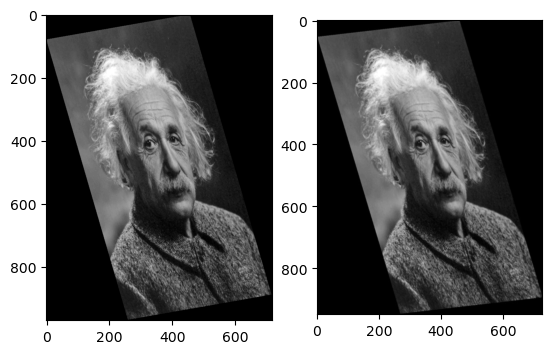

In [30]:
# comparing side by side
%matplotlib inline
plt.subplot(121)
plt.imshow(I2,cmap='gray')
plt.subplot(122)
plt.imshow(I_affineWarped,cmap='gray')

# Quiz: can you copy Affine transformation from one image and transform another image accordingly

In [29]:
dog = r'dog.jpg'
I_dog = cv2.imread(dog,cv2.IMREAD_GRAYSCALE)
I3 = f_transformProjective(A,I_dog)

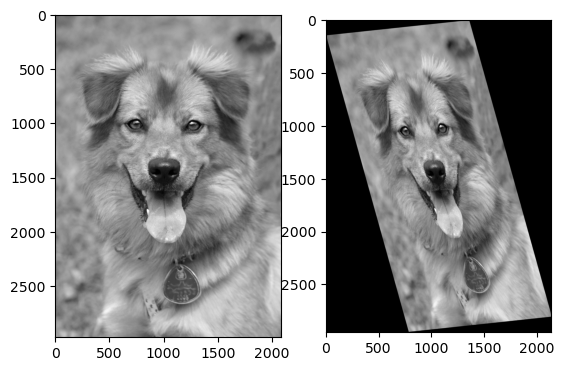

In [32]:
%matplotlib inline
plt.subplot(121)
plt.imshow(I_dog,cmap='gray')
plt.subplot(122)
plt.imshow(I3,cmap='gray')